In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Configurar semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

# Verificar si CUDA está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [28]:
# Cargar los datos desde CSV
data = pd.read_csv('bodyfat.csv')
print("Datos cargados correctamente.")
print(f"Dimensiones del dataset: {data.shape}")

# Mostrar las primeras filas
print("\nPrimeras filas del dataset:")
print(data.head())

# Verificar valores nulos
print("\nVerificando valores nulos:")
if data.isnull().sum().sum() > 0:
    print(data.isnull().sum())
    print("Eliminando filas con valores nulos...")
    data = data.dropna()
    print(f"Nuevas dimensiones del dataset: {data.shape}")
else:
    print("No hay valores nulos en el dataset.")

# Separar características y objetivo
X = data.drop('BodyFat', axis=1)
y = data['BodyF at'].values.reshape(-1, 1)

# Dividir en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nConjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

Datos cargados correctamente.
Dimensiones del dataset: (252, 15)

Primeras filas del dataset:
   Density  BodyFat  Age  Weight  Height  Neck  Chest  Abdomen    Hip  Thigh  \
0   1.0708     12.3   23  154.25   67.75  36.2   93.1     85.2   94.5   59.0   
1   1.0853      6.1   22  173.25   72.25  38.5   93.6     83.0   98.7   58.7   
2   1.0414     25.3   22  154.00   66.25  34.0   95.8     87.9   99.2   59.6   
3   1.0751     10.4   26  184.75   72.25  37.4  101.8     86.4  101.2   60.1   
4   1.0340     28.7   24  184.25   71.25  34.4   97.3    100.0  101.9   63.2   

   Knee  Ankle  Biceps  Forearm  Wrist  
0  37.3   21.9    32.0     27.4   17.1  
1  37.3   23.4    30.5     28.9   18.2  
2  38.9   24.0    28.8     25.2   16.6  
3  37.3   22.8    32.4     29.4   18.2  
4  42.2   24.0    32.2     27.7   17.7  

Verificando valores nulos:
No hay valores nulos en el dataset.


KeyError: 'BodyF at'

In [29]:
# Normalizar los datos
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convertir a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Crear DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
# Definir la arquitectura de la red neuronal multicapa
class MultiLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MultiLayerNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size2, output_size)
    
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.layer3(x)
        return x

# Parámetros del modelo
input_size = X_train.shape[1]
hidden_size1 = 32
hidden_size2 = 16
output_size = 1

# Crear el modelo y enviarlo al dispositivo (CPU o GPU)
model = MultiLayerNN(input_size, hidden_size1, hidden_size2, output_size).to(device)
print("\nArquitectura del modelo:")
print(model)


Arquitectura del modelo:
MultiLayerNN(
  (layer1): Linear(in_features=14, out_features=32, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=16, out_features=1, bias=True)
)


In [31]:
# Función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento
epochs = 30
train_losses = []
test_losses = []
train_r2_scores = []
test_r2_scores = []

print("\nIniciando entrenamiento...")
for epoch in range(epochs):
    # Modo entrenamiento
    model.train()
    running_loss = 0.0
    
    # Entrenar con batches
    for inputs, targets in train_loader:
        # Mover datos al dispositivo
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calcular pérdida media de entrenamiento por época
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # Evaluar en conjunto de entrenamiento para R²
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train_tensor.to(device))
        train_outputs_cpu = train_outputs.cpu().numpy()
        train_r2 = r2_score(y_train, train_outputs_cpu)
        train_r2_scores.append(train_r2)
        
        # Evaluar en conjunto de prueba
        test_outputs = model(X_test_tensor.to(device))
        test_outputs_cpu = test_outputs.cpu().numpy()
        test_loss = criterion(test_outputs, y_test_tensor.to(device)).item()
        test_losses.append(test_loss)
        test_r2 = r2_score(y_test, test_outputs_cpu)
        test_r2_scores.append(test_r2)
    
    # Imprimir progreso cada 
    if (epoch + 1) % 2 == 0:
        print(f'Época [{epoch+1}/{epochs}], Pérdida entrenamiento: {epoch_loss:.4f}, Pérdida prueba: {test_loss:.4f}')
        print(f'R² entrenamiento: {train_r2:.4f}, R² prueba: {test_r2:.4f}')

print("Entrenamiento completado.")



Iniciando entrenamiento...
Época [2/30], Pérdida entrenamiento: 0.2233, Pérdida prueba: 0.0936
R² entrenamiento: 0.8875, R² prueba: 0.8486
Época [4/30], Pérdida entrenamiento: 0.0551, Pérdida prueba: 0.0498
R² entrenamiento: 0.9534, R² prueba: 0.9194
Época [6/30], Pérdida entrenamiento: 0.0300, Pérdida prueba: 0.0200
R² entrenamiento: 0.9733, R² prueba: 0.9676
Época [8/30], Pérdida entrenamiento: 0.0198, Pérdida prueba: 0.0256
R² entrenamiento: 0.9807, R² prueba: 0.9587
Época [10/30], Pérdida entrenamiento: 0.0177, Pérdida prueba: 0.0123
R² entrenamiento: 0.9729, R² prueba: 0.9801
Época [12/30], Pérdida entrenamiento: 0.0263, Pérdida prueba: 0.0249
R² entrenamiento: 0.9727, R² prueba: 0.9598
Época [14/30], Pérdida entrenamiento: 0.0189, Pérdida prueba: 0.0150
R² entrenamiento: 0.9791, R² prueba: 0.9757
Época [16/30], Pérdida entrenamiento: 0.0169, Pérdida prueba: 0.0095
R² entrenamiento: 0.9844, R² prueba: 0.9847
Época [18/30], Pérdida entrenamiento: 0.0158, Pérdida prueba: 0.0185
R² 


Resultados finales:
Error cuadrático medio: 0.0093
Coeficiente de determinación (R²): 0.9849


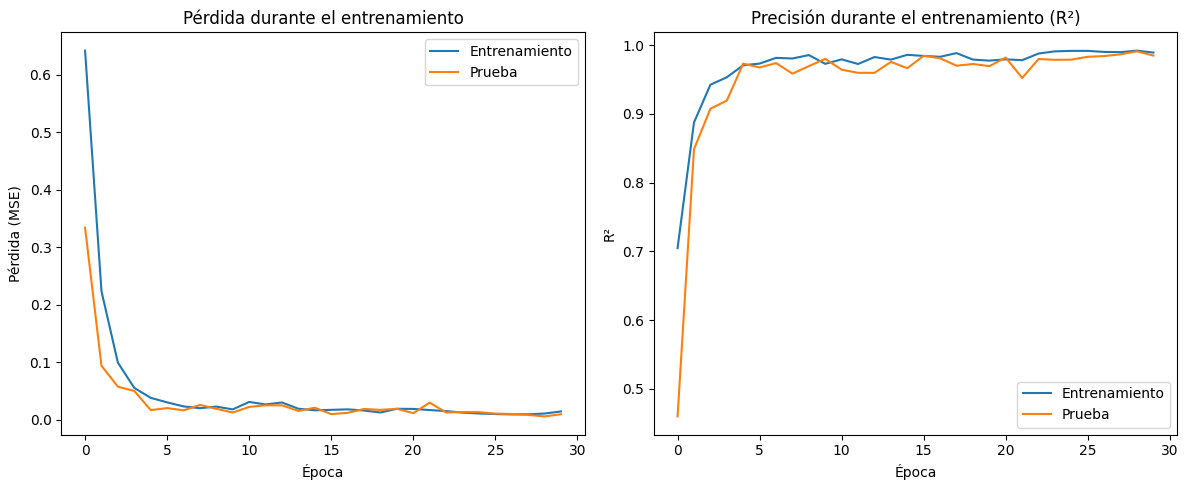

In [32]:
# Evaluar el modelo final en los datos de prueba
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).cpu().numpy()
    
    # Desnormalizar predicciones y valores reales
    y_pred_original = scaler_y.inverse_transform(y_pred)
    y_test_original = scaler_y.inverse_transform(y_test)
    
    # Calcular métricas finales
    mse = mean_squared_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)
    
    print(f'\nResultados finales:')
    print(f'Error cuadrático medio: {mse:.4f}')
    print(f'Coeficiente de determinación (R²): {r2:.4f}')

# Visualizaciones
plt.figure(figsize=(12, 5))

# Gráfica de pérdida
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Entrenamiento')
plt.plot(test_losses, label='Prueba')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()

# Gráfica de precisión (R²)
plt.subplot(1, 2, 2)
plt.plot(train_r2_scores, label='Entrenamiento')
plt.plot(test_r2_scores, label='Prueba')
plt.title('Precisión durante el entrenamiento (R²)')
plt.xlabel('Época')
plt.ylabel('R²')
plt.legend()

plt.tight_layout()
plt.show()